In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../data/clean_listings.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (396, 13)

Columns: ['location', 'property_type', 'bedrooms', 'bathrooms', 'parking', 'size_sqft', 'price_kes', 'price_per_sqft', 'listing_month', 'listing_year', 'location_tier', 'total_rooms', 'bed_bath_ratio']


,location,property_type,bedrooms,bathrooms,parking,size_sqft,price_kes,price_per_sqft,listing_month,listing_year,location_tier,total_rooms,bed_bath_ratio
0,Westlands,Apartment,1,1,1,732,8940000,12213.11,2,2026,High End,2,1.0
1,Westlands,Apartment,1,1,1,732,8940000,12213.11,2,2026,High End,2,1.0
2,Syokimau,Apartment,2,2,1,990,7500000,7575.76,2,2026,Mid Range,4,1.0
3,Westlands,Apartment,1,1,1,753,9200000,12217.80,2,2026,High End,2,1.0
4,Westlands,Apartment,1,1,1,721,9000000,12482.66,2,2026,High End,2,1.0


In [2]:
print("=" * 45)
print("QUESTION 1: Which locations are most expensive?")
print("=" * 45)
location_prices = (df.groupby('location')['price_kes']
                   .agg(['median', 'count'])
                   .sort_values('median', ascending=False))
location_prices['median_millions'] = (location_prices['median'] / 1e6).round(2)
print(location_prices.head(10))

print("\n" + "=" * 45)
print("QUESTION 2: How strongly does size affect price?")
print("=" * 45)
correlation = df['size_sqft'].corr(df['price_kes'])
print(f"Correlation between size and price: {correlation:.3f}")
print("(1.0 = perfect relationship, 0 = no relationship)")
if correlation > 0.7:
    print("Verdict: STRONG positive relationship")
elif correlation > 0.4:
    print("Verdict: MODERATE positive relationship")
else:
    print("Verdict: WEAK relationship — other factors matter more")

print("\n" + "=" * 45)
print("QUESTION 3: What drives price the most?")
print("=" * 45)
numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 
                'parking', 'total_rooms']
correlations = df[numeric_cols].corrwith(df['price_kes']).sort_values(ascending=False)
print(correlations.round(3))

QUESTION 1: Which locations are most expensive?
                   median  count  median_millions
location                                         
Kiambu Rd      35000000.0      3            35.00
Runda          35000000.0      4            35.00
Lavington      30000000.0      2            30.00
Muthangari     27790000.0      1            27.79
Spring Valley  23100000.0      1            23.10
Riverside      18300000.0      8            18.30
Kilimani       14400000.0     71            14.40
Westlands      13000000.0    233            13.00
Kileleshwa      9210000.0     54             9.21
Syokimau        8000000.0     14             8.00

QUESTION 2: How strongly does size affect price?
Correlation between size and price: 0.782
(1.0 = perfect relationship, 0 = no relationship)
Verdict: STRONG positive relationship

QUESTION 3: What drives price the most?
total_rooms    0.909
bathrooms      0.905
bedrooms       0.886
size_sqft      0.782
parking        0.297
dtype: float64


In [3]:

df_model = df.copy()

le_location = LabelEncoder()
le_type = LabelEncoder()
le_tier = LabelEncoder()

df_model['location_encoded'] = le_location.fit_transform(df_model['location'])
df_model['property_type_encoded'] = le_type.fit_transform(df_model['property_type'])
df_model['tier_encoded'] = le_tier.fit_transform(df_model['location_tier'])

features = [
    'bedrooms', 
    'bathrooms', 
    'size_sqft', 
    'parking',
    'total_rooms',
    'location_encoded',
    'property_type_encoded',
    'tier_encoded',
    'listing_month'
]

target = 'price_kes'

X = df_model[features]
y = df_model[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {features}")

Features shape: (396, 9)
Target shape: (396,)

Feature columns: ['bedrooms', 'bathrooms', 'size_sqft', 'parking', 'total_rooms', 'location_encoded', 'property_type_encoded', 'tier_encoded', 'listing_month']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=42     
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nTraining = {len(X_train)/len(X)*100:.0f}% of data")
print(f"Testing = {len(X_test)/len(X)*100:.0f}% of data")

Training samples: 316
Testing samples: 80

Training = 80% of data
Testing = 20% of data


In [6]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


y_pred = lr_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=" * 45)
print("LINEAR REGRESSION — BASELINE PERFORMANCE")
print("=" * 45)
print(f"\nMAE:  KES {mae:,.0f}")
print(f"RMSE: KES {rmse:,.0f}")
print(f"R²:   {r2:.3f}")

print(f" On average, predictions are off by KES {mae:,.0f}")
print(f" The model explains {r2*100:.1f}% of price variation")

LINEAR REGRESSION — BASELINE PERFORMANCE

MAE:  KES 2,285,002
RMSE: KES 3,741,978
R²:   0.806
 On average, predictions are off by KES 2,285,002
 The model explains 80.6% of price variation


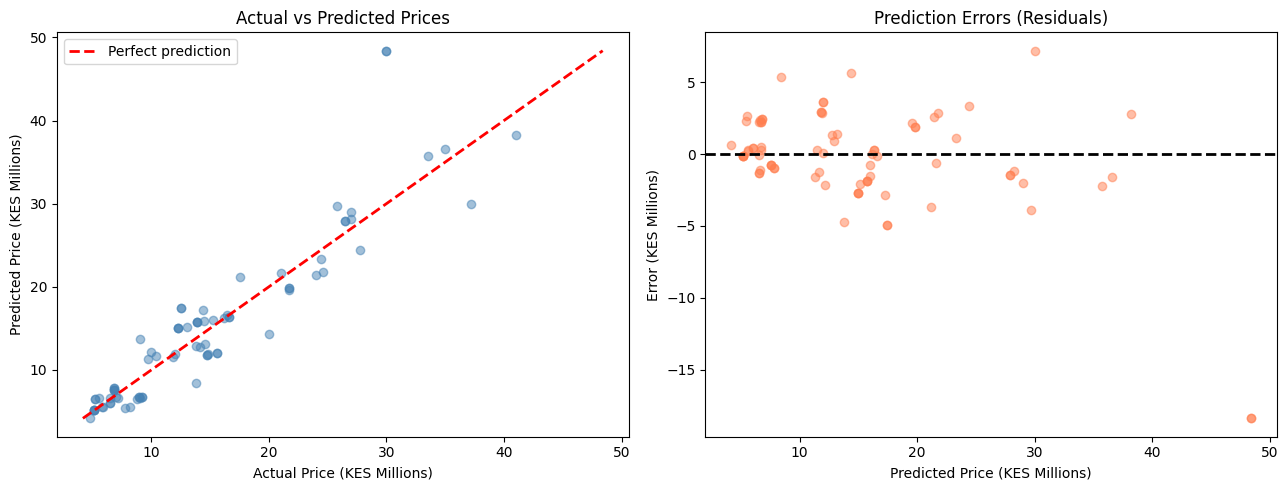

Charts saved


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(y_test / 1e6, y_pred / 1e6, alpha=0.5, color='steelblue')
min_val = min(y_test.min(), y_pred.min()) / 1e6
max_val = max(y_test.max(), y_pred.max()) / 1e6
ax1.plot([min_val, max_val], [min_val, max_val], 
         'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual Price (KES Millions)')
ax1.set_ylabel('Predicted Price (KES Millions)')
ax1.set_title('Actual vs Predicted Prices')
ax1.legend()

residuals = y_test - y_pred
ax2.scatter(y_pred / 1e6, residuals / 1e6, alpha=0.5, color='coral')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Price (KES Millions)')
ax2.set_ylabel('Error (KES Millions)')
ax2.set_title('Prediction Errors (Residuals)')

plt.tight_layout()
plt.savefig('../docs/baseline_model.png', dpi=150, bbox_inches='tight')
plt.show()

print("Charts saved")

In [8]:
results = {
    'model': ['Linear Regression (Baseline)'],
    'MAE_kes': [round(mae)],
    'RMSE_kes': [round(rmse)],
    'R2': [round(r2, 3)]
}

results_df = pd.DataFrame(results)
results_df.to_csv('../data/model_results.csv', index=False)

print("Model results saved.")
print(results_df)

Model results saved.
                          model  MAE_kes  RMSE_kes     R2
0  Linear Regression (Baseline)  2285002   3741978  0.806


In [9]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,    # 200 decision trees
    max_depth=15,        # how deep each tree can grow
    min_samples_split=5, # minimum samples needed to split a node
    random_state=42      # reproducibility
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("=" * 45)
print("RANDOM FOREST PERFORMANCE")
print("=" * 45)
print(f"\nMAE:  KES {rf_mae:,.0f}")
print(f"RMSE: KES {rf_rmse:,.0f}")
print(f"R²:   {rf_r2:.3f}")
print(f"→ On average, predictions are off by KES {rf_mae:,.0f}")
print(f"→ The model explains {rf_r2*100:.1f}% of price variation")

RANDOM FOREST PERFORMANCE

MAE:  KES 946,941
RMSE: KES 1,869,885
R²:   0.952
→ On average, predictions are off by KES 946,941
→ The model explains 95.2% of price variation


In [10]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression (Baseline)', 'Random Forest'],
    'MAE (KES)': [f"{mae:,.0f}", f"{rf_mae:,.0f}"],
    'RMSE (KES)': [f"{rmse:,.0f}", f"{rf_rmse:,.0f}"],
    'R²': [f"{r2:.3f}", f"{rf_r2:.3f}"]
})

print("=" * 55)
print("MODEL COMPARISON")
print("=" * 55)
print(comparison.to_string(index=False))

improvement = ((mae - rf_mae) / mae * 100)
print(f"\nRandom Forest improved MAE by {improvement:.1f}% over baseline")

MODEL COMPARISON
                       Model MAE (KES) RMSE (KES)    R²
Linear Regression (Baseline) 2,285,002  3,741,978 0.806
               Random Forest   946,941  1,869,885 0.952

Random Forest improved MAE by 58.6% over baseline


TOP PRICE DRIVERS:
                 feature  importance
2              size_sqft    0.516829
1              bathrooms    0.234491
4            total_rooms    0.196560
3                parking    0.020858
5       location_encoded    0.013136
7           tier_encoded    0.011502
0               bedrooms    0.005929
6  property_type_encoded    0.000695
8          listing_month    0.000000


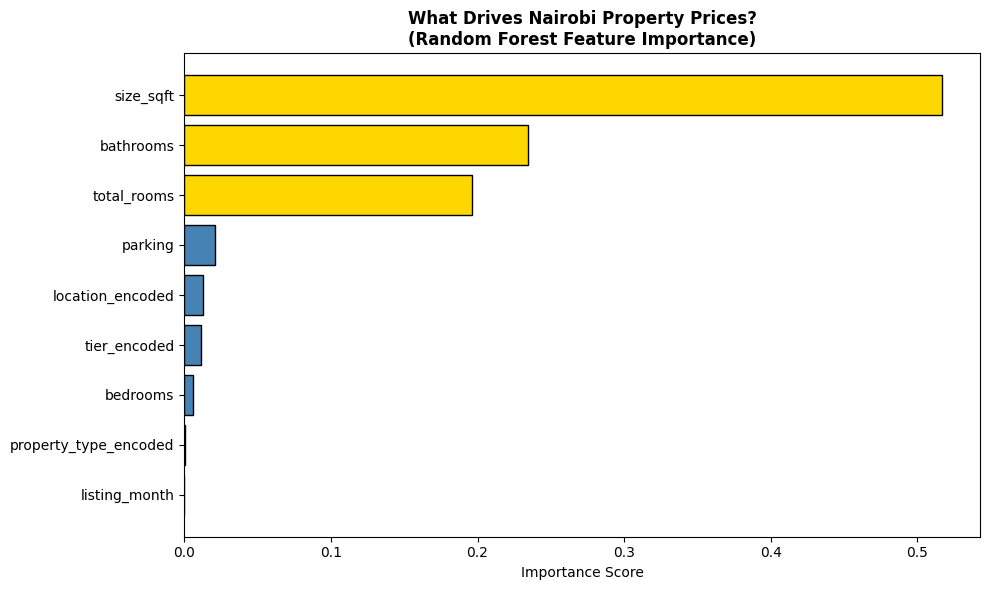

Feature importance chart saved


In [11]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("TOP PRICE DRIVERS:")
print(feature_importance_df)


plt.figure(figsize=(10, 6))
colors = ['gold' if i < 3 else 'steelblue' 
          for i in range(len(feature_importance_df))]
plt.barh(feature_importance_df['feature'], 
         feature_importance_df['importance'],
         color=colors, edgecolor='black')
plt.xlabel('Importance Score')
plt.title('What Drives Nairobi Property Prices?\n(Random Forest Feature Importance)',
          fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../docs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Feature importance chart saved")

In [12]:
import pickle

with open('../data/model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('../data/encoders.pkl', 'wb') as f:
    pickle.dump({
        'location': le_location,
        'property_type': le_type,
        'tier': le_tier
    }, f)


results_df = pd.DataFrame({
    'model': ['Linear Regression (Baseline)', 'Random Forest'],
    'MAE_kes': [round(mae), round(rf_mae)],
    'RMSE_kes': [round(rmse), round(rf_rmse)],
    'R2': [round(r2, 3), round(rf_r2, 3)]
})
results_df.to_csv('../data/model_results.csv', index=False)

print(" model.pkl saved")
print(" encoders.pkl saved")
print(" model_results.csv updated")
print(f"\nFinal model: Random Forest")
print(f"MAE: KES {rf_mae:,.0f}")
print(f"R²: {rf_r2:.3f}")

 model.pkl saved
 encoders.pkl saved
 model_results.csv updated

Final model: Random Forest
MAE: KES 946,941
R²: 0.952


In [13]:

import json

model_metadata = {
    'features': features,
    'locations': list(le_location.classes_),
    'property_types': list(le_type.classes_),
    'location_tiers': list(le_tier.classes_),
    'mae': round(rf_mae),
    'r2': round(rf_r2, 3),
    'median_price': int(df['price_kes'].median())
}

with open('../data/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("model_metadata.json saved")
print(f"\nLocations available: {model_metadata['locations']}")
print(f"Property types available: {model_metadata['property_types']}")

model_metadata.json saved

Locations available: ['Kabete', 'Kiambu Rd', 'Kileleshwa', 'Kilimani', 'Lavington', 'Mirema', 'Muthangari', 'Riverside', 'Runda', 'Spring Valley', 'Syokimau', 'Westlands']
Property types available: ['Apartment', 'House', 'Townhouse']
